# <center>**Aspect-based Financial Sentiment Analysis**</center>

For this problem statement I have used an approach to leverage pretrained Large Language Models such as distilbert-base-uncased, finbert, flan-t5-base, and fine-tuned them for a specific task. I have used LoRA for parameter efficient fine-tuning to expedite the model training.

## Document Flow

1.   **Exploratory Data Analysis.**
2.   **Aspect Classification:** Fine-tuning distilbert-base-uncased, finbert for text classification. Using LoRA for parameter efficient fine-tuning.
3.   **Financial Sentiment Analysis:** Fine-tuning distilbert-base-uncased, finbert for sentiment analysis. Using LoRA for parameter efficient fine-tuning.
4.   **Detecting Target from sentence:** Fine-tuning flan-t5-base for sequence to sequence model. Using LoRA for parameter efficient fine-tuning.









In [ ]:
!pip install datasets
!pip install peft
!pip install evaluate rouge-score nltk

In [ ]:
from datasets import load_dataset, DatasetDict, Dataset
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import re
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import AutoTokenizer
from evaluate import load

<br>

# <center>Exploratory Data Analysis<center>


1.   Loading the dataset.
2.   Analyzing and understanding the dataset. Converting it to pandas dataframe for further data analysis.
3.   Plotting useful graphs.




In [ ]:
dataset = load_dataset("pauri32/fiqa-2018")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'snippets', 'target', 'sentiment_score', 'aspects', 'format', 'label'],
        num_rows: 961
    })
    validation: Dataset({
        features: ['sentence', 'snippets', 'target', 'sentiment_score', 'aspects', 'format', 'label'],
        num_rows: 102
    })
    test: Dataset({
        features: ['sentence', 'snippets', 'target', 'sentiment_score', 'aspects', 'format', 'label'],
        num_rows: 150
    })
})

In [ ]:
dataset['train']

Dataset({
    features: ['sentence', 'snippets', 'target', 'sentiment_score', 'aspects', 'format', 'label'],
    num_rows: 961
})

In [ ]:
dataset['train'][0]

{'sentence': 'Still short $LNG from $11.70 area...next stop could be down through $9.00. Someone slammed it hard with 230,000 shs this am! More to follow',
 'snippets': "['Still short $LNG from $11.70 area...next stop could be down through $9.00.']",
 'target': 'LNG',
 'sentiment_score': -0.543,
 'aspects': "['Stock/Price Action/Volatility/Short Selling']",
 'format': 'post',
 'label': 2}

In [ ]:
print(dataset['train'].features)

{'sentence': Value(dtype='string', id=None), 'snippets': Value(dtype='string', id=None), 'target': Value(dtype='string', id=None), 'sentiment_score': Value(dtype='float64', id=None), 'aspects': Value(dtype='string', id=None), 'format': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}


In [ ]:
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [ ]:
train_dataset_df = dataset['train'].to_pandas()
validation_dataset_df = dataset['validation'].to_pandas()
test_dataset_df = dataset['test'].to_pandas()

<br>

## **Plot for train-test-validation split on "label"**

Analysis on 'label' column. Checking distribution across train, test, and validation splits of the dataset.

We can observe that the data is imbalanced and has very small number of samples for label - 1. This can cause inconsistency in training and can hamper the accuracy. Some methods used to handel this can be, adding more data, assigning class weights. While these methods were not implemented in this code, pretrained LLMs often gives decent results with this imbalance in data.

<br>


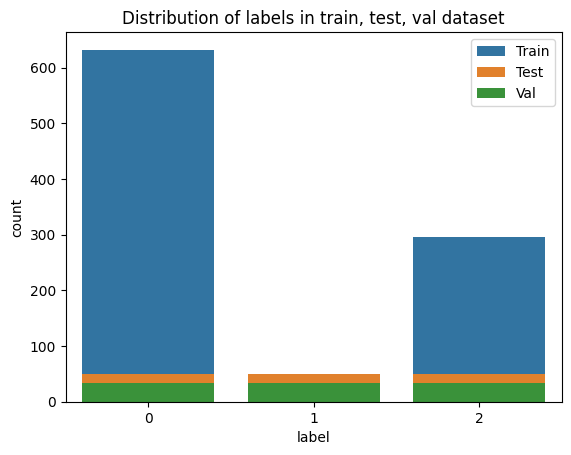

In [ ]:
plt.title('Distribution of labels in train, test, val dataset')
sns.countplot(x='label', data=train_dataset_df, label='Train')
sns.countplot(x='label', data=test_dataset_df, label='Test')
sns.countplot(x='label', data=validation_dataset_df, label='Val')
plt.legend()
plt.show()

In [ ]:
train_dataset_df['label'].value_counts()

label
0    632
2    295
1     34
Name: count, dtype: int64

<br>

## **Plot for checking sentiment-score Ranges**

This plot helps to understand the sentiment range associated with each label (0,1,2).

* label 0 ranges from 0.101 to 0.975
* label 1 ranges from -0.092 to 0.1
* label 2 ranges from -0.854 to -0.113

Understanding these sentiment ranges helps in deciding the appropriate sentiment score thresholds for classifying text into sentiment categories.

With respect to the sentiment classes the labels are as follows:

* label 0 is Positive Sentiment.
* label 1 is Neutral Sentiment.
* label 2 is Negative Sentiment.

<br>



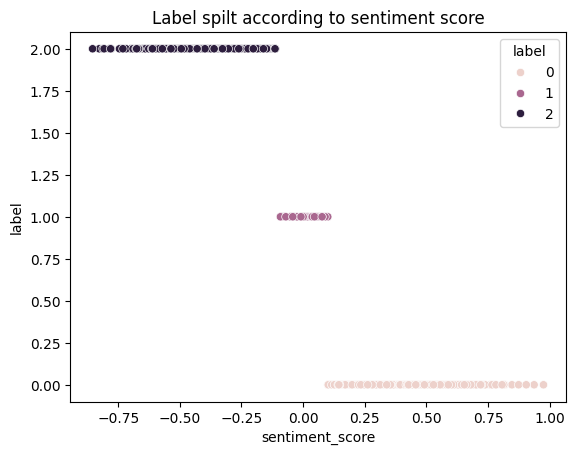

In [ ]:
plt.title('Label spilt according to sentiment score')
sns.scatterplot(x='sentiment_score',y='label', data=train_dataset_df, hue='label')
plt.show()

In [ ]:
label_2_subset = train_dataset_df[train_dataset_df['label'] == 2]
label_1_subset = train_dataset_df[train_dataset_df['label'] == 1]
label_0_subset = train_dataset_df[train_dataset_df['label'] == 0]

max_sentiment_score_label_2 = label_2_subset['sentiment_score'].max()
smallest_sentiment_score_label_2 = label_2_subset['sentiment_score'].min()

max_sentiment_score_label_1 = label_1_subset['sentiment_score'].max()
smallest_sentiment_score_label_1 = label_1_subset['sentiment_score'].min()

max_sentiment_score_label_0 = label_0_subset['sentiment_score'].max()
smallest_sentiment_score_label_0 = label_0_subset['sentiment_score'].min()

print("Min sentiment score with label 2:", smallest_sentiment_score_label_2)
print("Max sentiment score with label 2:", max_sentiment_score_label_2)
print("Min sentiment score with label 1:", smallest_sentiment_score_label_1)
print("Max sentiment score with label 1:", max_sentiment_score_label_1)
print("Min sentiment score with label 0:", smallest_sentiment_score_label_0)
print("Max sentiment score with label 0:", max_sentiment_score_label_0)

Min sentiment score with label 2: -0.854
Max sentiment score with label 2: -0.113
Min sentiment score with label 1: -0.092
Max sentiment score with label 1: 0.1
Min sentiment score with label 0: 0.101
Max sentiment score with label 0: 0.975


<br>

## **Plot for ditribution of Sentiment score**

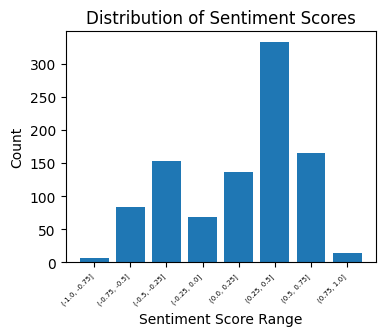

In [ ]:
bins = np.arange(-1, 1.25, 0.25)
sentiment_series = pd.Series(train_dataset_df['sentiment_score'])
counts = pd.cut(sentiment_series, bins).value_counts(sort=False)
plt.figure(figsize=(4, 3))
plt.bar(counts.index.astype(str), counts.values)

plt.xlabel('Sentiment Score Range')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Scores')
plt.xticks(rotation=45, ha='right',fontsize=5)
plt.show()

## **Analysis for aspects**

There are 125 unique aspects in the training dataset. These will be used for classification of aspects later in the code.

In [ ]:
len(train_dataset_df['aspects'].unique())

# aspect has 125 unique
# target has 457 unique

125

In [ ]:
test_dataset_df['aspects'].value_counts()

In [ ]:
train_dataset_df['aspects'].value_counts()

aspects
['Stock/Price Action/Bullish']                     76
['Stock/Technical Analysis']                       68
['Stock/Price Action']                             67
['Stock/Price Action/Bullish/Bullish Behavior']    66
['Stock/Price Action/Bearish']                     43
                                                   ..
['Corporate/Financial/Accounting']                  1
['Corporate/Reputation/Dispute']                    1
['Stock/Coverage/Stock Coverage']                   1
['Corporate/Dividend Policy/Dividend']              1
['Corporate/Sales/Failed Contract Discussion']      1
Name: count, Length: 125, dtype: int64

<br>

## **Plot for train-test-validation split on "aspects"**

Analysis on 'aspects' column. distribution across different splits of the 'aspects' column in the train, test, and validation datasets.

We can observe that the majority of aspect categories present in the test dataset also exist in both the train and validation datasets. However, there are variations in the counts of individual categories. Some categories have a higher frequency, while others are less common. I will elaborate on my approach to addressing this discrepancy in the subsequent discussion.

<br>


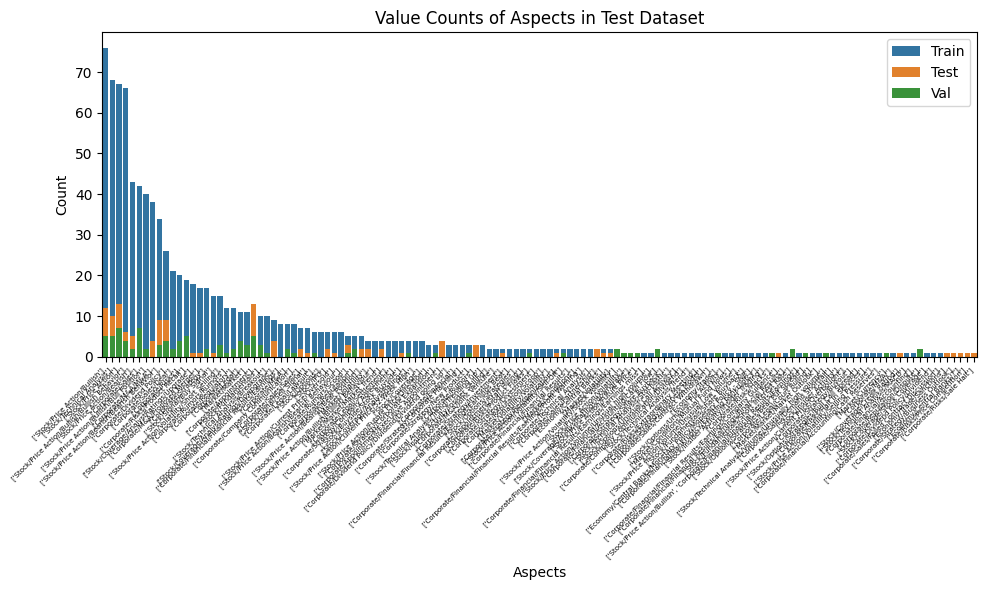

In [ ]:
aspects_value_counts_train = train_dataset_df['aspects'].value_counts()
aspects_value_counts_test = test_dataset_df['aspects'].value_counts()
aspects_value_counts_val = validation_dataset_df['aspects'].value_counts()

# Checking the amount of unseen aspects categories for the model
plt.figure(figsize=(10, 6))
sns.barplot(x=aspects_value_counts_train.index, y=aspects_value_counts_train.values, label='Train')
sns.barplot(x=aspects_value_counts_test.index, y=aspects_value_counts_test.values, label='Test')
sns.barplot(x=aspects_value_counts_val.index, y=aspects_value_counts_val.values, label='Val')
plt.title('Value Counts of Aspects in Test Dataset')
plt.xlabel('Aspects')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right',fontsize=5)
plt.tight_layout()
plt.legend()
plt.show()


<br>

## **Analysis on 'sentence' column**


*   No Null values.
*   Validation dataset have some duplicates. But thats fine.
*   Max and Min lengths of sentences:<br>

  Max:  147

  Min:  10


In [ ]:
print("Check Null values")
train_dataset_df['sentence'].isna().sum()
test_dataset_df['sentence'].isna().sum()
validation_dataset_df['sentence'].isna().sum()

Check Null values


0

In [ ]:
print("Check duplicates")
print(len(train_dataset_df['sentence'].unique()), len(train_dataset_df['sentence']))
print(len(test_dataset_df['sentence'].unique()), len(test_dataset_df['sentence']))
print(len(validation_dataset_df['sentence'].unique()), len(validation_dataset_df['sentence']))

Check duplicates
961 961
150 150
87 102


In [ ]:
print("Max and Min lengths of sentences")
print('Max: ',train_dataset_df['sentence'].apply(lambda x: len(x)).max())
print('Min: ',train_dataset_df['sentence'].apply(lambda x: len(x)).min())

Max and Min lengths of sentences
Max:  147
Min:  10


In [ ]:
print("Max and Min words/tokens of sentences")
print('Max: ',train_dataset_df['sentence'].apply(lambda x: len(x.split())).max())
print('Min: ',train_dataset_df['sentence'].apply(lambda x: len(x.split())).min())

Max and Min words/tokens of sentences
Max:  29
Min:  2


<br>

# **Task 1**

---



<br>

# **Model for Sentiment Analysis by fine-tuning distilbert-base-uncased and  using LoRA**

**Model:** 'distilbert-base-uncased'

DistilBERT is a smaller and faster version of BERT, designed to be more computationally efficient while retaining much of the performance of the original BERT model. Despite of being smaller than BERT it has shown comparable performance. DistilBERT is trained on large corpus of text data, since this task is understanding and classifying text, I chose DistilBERT for this task.

**Metric:**

The metrics used for evaluating the model are Accuracy, Precision, Recall, f1 score and confusion matrix. These are some standard metric to judge the performance of a classifier.
These help in understanding the classifier's behaviour and how well it performs in classifying the text.

**Desciption:**

There are text instance in the financial domain, for this task we need to predict the sentiment of the text.

I am approaching this as a classification problem and classifying the text as Positive(0), Neutral(1) or Negative(2). As dicussed above, I decided the range for sentiment score using the label classes and they are as follow:

* label 0 ranges from 0.101 to 0.975
* label 1 ranges from -0.092 to 0.1
* label 2 ranges from -0.854 to -0.113

**Training:**

Used the distilbert-base-uncased model which will classify the text into either Positive, Neutral or Negative sentiment. The code below explains:

* Evaluate performance of model before fine-tuning.
* Tokenizing the text and getting the embeddings. Converting them into tensors.
* Configuring LoRA for parameter efficient fine-tuning and making the training faster with lesser parameters while maintaining efficiency.
* Using Trainer() class from huggingface to train the model.
* Evaluate performance of model after fine-tuning.
* Hyperparameter tuning.

**Performance:**

Before fine-tuning:

accuracy {'accuracy': 0.26} precision {'precision': 0.26} recall {'recall': 0.26} f1 {'f1': 0.26}

Best model after fine-tuning:

accuracy {'accuracy': 0.5933333333333334} precision {'precision': 0.5933333333333334} recall {'recall': 0.5933333333333334} f1 {'f1': 0.5933333333333334}



<br>


## Model

In [ ]:
model_checkpoint = 'distilbert-base-uncased'

id2label = {0: "Positive", 1: "Neutral", 2: "Negative"}
label2id = {"Positive":0, "Neutral":1, "Negative":2}

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=3, id2label=id2label, label2id=label2id)

In [ ]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda"
model.to(device)
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels), "precision": precision.compute(predictions=predictions, references=labels, average="micro"),
            "recall": recall.compute(predictions=predictions, references=labels, average="micro"), "f1": f1.compute(predictions=predictions, references=labels, average="micro")}

<br>

# Evaluating the model performance Before fine-tuning

### On Test dataset.
<br>

In [ ]:
print("Untrained model predictions:")
print("----------------------------")

i = 0
for example in dataset['test']:
    if i == 10:
      break
    text = example['sentence']
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    logits = model(inputs).logits
    predictions = torch.argmax(logits)
    print(text + " - " + id2label[predictions.tolist()])
    i+=1

Untrained model predictions:
----------------------------
$HCP Come to the party and buy this -gonna give solid gains and a dividend $$$$$$ - Neutral
@gakrum nice chart shows distinctive down channel not a dip.. where do you see the bottom? $SPY ..$150? ..$130? - Neutral
Japan's Asahi to submit bid next week for SABMiller's Grolsch and Peroni - Yomiuri - Neutral
Tesla Motors recalls 2,700 Model X SUVs $TSLA https://t.co/F55dx4aegI - Neutral
CRH's concrete bid for Holcim Lafarge assets - Neutral
Doubts grow over GlaxoSmithKline's $6 bln capital return plan - Neutral
$XLF http://stks.co/1KJ9 Bounced off target buy area, bought $skf as a hedge. watch 50ma's slope - Neutral
$TSLA looking good..i'd love to see a basing action here, letting the RSI take a breather. http://stks.co/g1T7c - Neutral
France raises concerns over proposed LSE-Deutsche Boerse deal - Neutral
Qualcomm: 10% Dividend Increase Rewards Patient Investors, The Future Looks Bright https://t.co/TJjVpqhHqD $QCOM - Negative


In [ ]:
true_labels = dataset['test']['label']
predicted_labels = []

for example in dataset['test']:
    text = example['sentence']
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    logits = model(inputs).logits
    predictions = torch.argmax(logits)
    predicted_labels.append(predictions.item())

predicted_labels

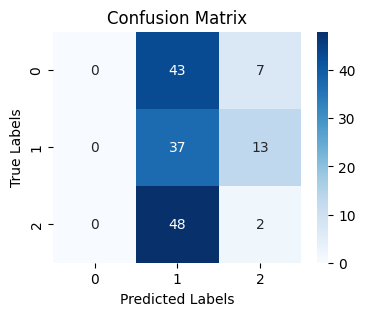

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Metrics before fine-tuning")
print("accuracy", accuracy.compute(predictions=predicted_labels, references=true_labels), "precision", precision.compute(predictions=predicted_labels, references=true_labels, average="micro"),
"recall", recall.compute(predictions=predicted_labels, references=true_labels, average="micro"), "f1", f1.compute(predictions=predicted_labels, references=true_labels, average="micro"))

Metrics before fine-tuning
accuracy {'accuracy': 0.26} precision {'precision': 0.26} recall {'recall': 0.26} f1 {'f1': 0.26}


### On Validation Dataset.

In [ ]:
true_labels_val = dataset['validation']['label']
predicted_labels_val_before = []

for example in dataset['validation']:
    text = example['sentence']
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    logits = model(inputs).logits
    predictions = torch.argmax(logits)
    predicted_labels_val_before.append(predictions.item())

predicted_labels_val_before

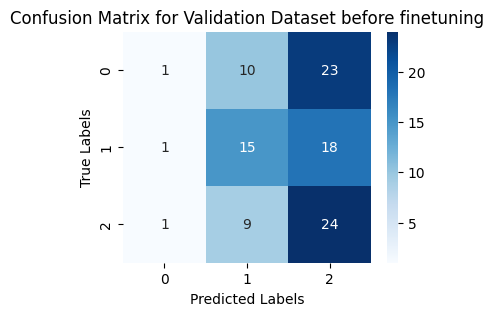

In [ ]:
cm = confusion_matrix(true_labels_val, predicted_labels_val_before)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Validation Dataset before finetuning')
plt.show()

In [ ]:
print("Metrics before fine-tuning")
print("accuracy", accuracy.compute(predictions=predicted_labels_val_before, references=true_labels_val), "precision", precision.compute(predictions=predicted_labels_val_before, references=true_labels_val, average="micro"),
"recall", recall.compute(predictions=predicted_labels_val_before, references=true_labels_val, average="micro"), "f1", f1.compute(predictions=predicted_labels_val_before, references=true_labels_val, average="micro"))

Metrics before fine-tuning
accuracy {'accuracy': 0.39215686274509803} precision {'precision': 0.39215686274509803} recall {'recall': 0.39215686274509803} f1 {'f1': 0.39215686274509803}


<br>

# Fine-Tuning distilbert-base-uncased for Sentiment Analysis. Using LoRA for parameter efficient fine-tuning.

Tokenize dataset


In [ ]:
def tokenize_function(examples):

    sentence = examples['sentence']

    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        sentence,
        return_tensors="np",
        truncation=True,
        max_length=150,
        padding="max_length"
    )

    return tokenized_inputs

In [ ]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)

In [ ]:
tokenized_dataset.set_format(type="torch", columns=['label', 'input_ids', 'attention_mask'])

In [ ]:
# hyperparameters
lr = 1e-3
batch_size = 16
num_epochs = 3

### Configure LoRA

In [ ]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ['q_lin'])

In [ ]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules={'q_lin'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [ ]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 629,763 || all params: 67,585,542 || trainable%: 0.9318013607111414


## Train the model

In [ ]:
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/fin_opinion/" + model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.319337,{'accuracy': 0.5490196078431373},{'precision': 0.5490196078431373},{'recall': 0.5490196078431373},{'f1': 0.5490196078431373}
2,No log,1.039630,{'accuracy': 0.6078431372549019},{'precision': 0.6078431372549019},{'recall': 0.6078431372549019},{'f1': 0.6078431372549019}
3,No log,1.033676,{'accuracy': 0.6274509803921569},{'precision': 0.6274509803921569},{'recall': 0.6274509803921569},{'f1': 0.6274509803921569}


Trainer is attempting to log a value of "{'accuracy': 0.5490196078431373}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.5490196078431373}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.5490196078431373}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.5490196078431373}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.6078431372549019}" of type <class 

TrainOutput(global_step=183, training_loss=0.5292546423406549, metrics={'train_runtime': 25.9702, 'train_samples_per_second': 111.012, 'train_steps_per_second': 7.047, 'total_flos': 113521835421000.0, 'train_loss': 0.5292546423406549, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.898379,{'accuracy': 0.6372549019607843},{'precision': 0.6372549019607843},{'recall': 0.6372549019607843},{'f1': 0.6372549019607843}
2,No log,0.655938,{'accuracy': 0.7156862745098039},{'precision': 0.7156862745098039},{'recall': 0.7156862745098039},{'f1': 0.7156862745098039}
3,No log,0.654609,{'accuracy': 0.6764705882352942},{'precision': 0.6764705882352942},{'recall': 0.6764705882352942},{'f1': 0.6764705882352942}


Trainer is attempting to log a value of "{'accuracy': 0.6372549019607843}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.6372549019607843}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.6372549019607843}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6372549019607843}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.7156862745098039}" of type <class 

TrainOutput(global_step=183, training_loss=0.26411740245714865, metrics={'train_runtime': 26.1182, 'train_samples_per_second': 110.383, 'train_steps_per_second': 7.007, 'total_flos': 113521835421000.0, 'train_loss': 0.26411740245714865, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.563906,{'accuracy': 0.7549019607843137},{'precision': 0.7549019607843137},{'recall': 0.7549019607843137},{'f1': 0.7549019607843137}
2,No log,0.277076,{'accuracy': 0.8725490196078431},{'precision': 0.8725490196078431},{'recall': 0.8725490196078431},{'f1': 0.8725490196078431}
3,No log,0.281572,{'accuracy': 0.8921568627450981},{'precision': 0.8921568627450981},{'recall': 0.8921568627450981},{'f1': 0.8921568627450981}


Trainer is attempting to log a value of "{'accuracy': 0.7549019607843137}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.7549019607843137}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.7549019607843137}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.7549019607843137}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8725490196078431}" of type <class 

TrainOutput(global_step=183, training_loss=0.1385642921989733, metrics={'train_runtime': 26.9543, 'train_samples_per_second': 106.959, 'train_steps_per_second': 6.789, 'total_flos': 113521835421000.0, 'train_loss': 0.1385642921989733, 'epoch': 3.0})

<br>

## Checkpointing model performance and saving the model.

Mainly to ensure if the model is not overfitting.

In [ ]:
predicted_labels = []

for example in dataset['test']:
    text = example['sentence']
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    logits = model(inputs).logits
    predictions = torch.argmax(logits)

    predicted_labels.append(predictions.item())

predicted_labels

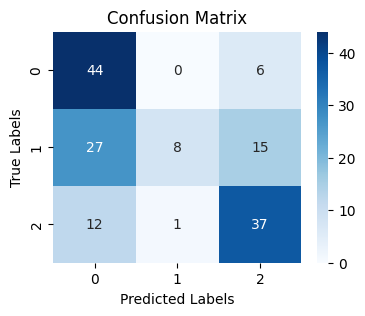

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Metrics after fine-tuning")
print("accuracy", accuracy.compute(predictions=predicted_labels, references=true_labels), "precision", precision.compute(predictions=predicted_labels, references=true_labels, average="micro"),
"recall", recall.compute(predictions=predicted_labels, references=true_labels, average="micro"), "f1", f1.compute(predictions=predicted_labels, references=true_labels, average="micro"))

Metrics after fine-tuning
accuracy {'accuracy': 0.5933333333333334} precision {'precision': 0.5933333333333334} recall {'recall': 0.5933333333333334} f1 {'f1': 0.5933333333333334}


<br>

### Note: The above is the best accuracy model.

<br>

In [ ]:
model_path = "/content/drive/MyDrive/fin_opinion/saved_model/model"
trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

#### Trianing for another 3 epochs.

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.083914,{'accuracy': 0.9509803921568627},{'precision': 0.9509803921568627},{'recall': 0.9509803921568627},{'f1': 0.9509803921568627}
2,No log,0.032892,{'accuracy': 0.9803921568627451},{'precision': 0.9803921568627451},{'recall': 0.9803921568627451},{'f1': 0.9803921568627451}
3,No log,0.011926,{'accuracy': 1.0},{'precision': 1.0},{'recall': 1.0},{'f1': 1.0}


Trainer is attempting to log a value of "{'accuracy': 0.9509803921568627}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9509803921568627}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9509803921568627}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9509803921568627}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9803921568627451}" of type <class 

TrainOutput(global_step=183, training_loss=0.04824311615990811, metrics={'train_runtime': 29.1273, 'train_samples_per_second': 98.979, 'train_steps_per_second': 6.283, 'total_flos': 113521835421000.0, 'train_loss': 0.04824311615990811, 'epoch': 3.0})

In [ ]:
predicted_labels = []

for example in dataset['test']:
    text = example['sentence']
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    logits = model(inputs).logits
    predictions = torch.argmax(logits)

    predicted_labels.append(predictions.item())

predicted_labels

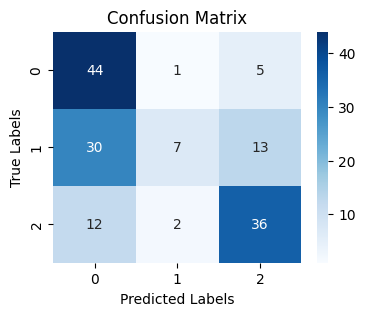

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Metrics before fine-tuning")
print("accuracy", accuracy.compute(predictions=predicted_labels, references=true_labels), "precision", precision.compute(predictions=predicted_labels, references=true_labels, average="micro"),
"recall", recall.compute(predictions=predicted_labels, references=true_labels, average="micro"), "f1", f1.compute(predictions=predicted_labels, references=true_labels, average="micro"))

Metrics before fine-tuning
accuracy {'accuracy': 0.58} precision {'precision': 0.58} recall {'recall': 0.58} f1 {'f1': 0.58}


<br>

### Model can be overfitting to the train data. Stopping the training.

In [ ]:
model_path = "/content/drive/MyDrive/fin_opinion/saved_model/model2"
trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

<br>

## Evaluation on Validation Dataset after fine-tuning

Checking the performance of model on validation dataset for analysis purpose.

<br>


In [ ]:
predicted_labels = []

for example in dataset['validation']:
    text = example['sentence']
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    logits = model(inputs).logits
    predictions = torch.argmax(logits)
    predicted_labels.append(predictions.item())

predicted_labels

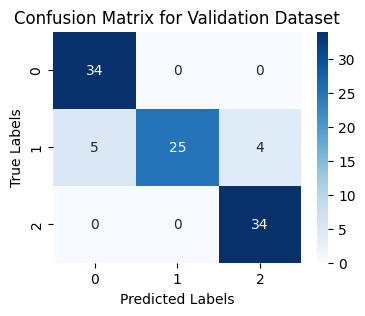

In [ ]:
cm = confusion_matrix(true_labels_val, predicted_labels)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Validation Dataset')
plt.show()

In [ ]:
print("Metrics after fine-tuning")
print("accuracy", accuracy.compute(predictions=predicted_labels, references=true_labels_val), "precision", precision.compute(predictions=predicted_labels, references=true_labels_val, average="micro"),
"recall", recall.compute(predictions=predicted_labels, references=true_labels_val, average="micro"), "f1", f1.compute(predictions=predicted_labels, references=true_labels_val, average="micro"))

Metrics after fine-tuning
accuracy {'accuracy': 0.9117647058823529} precision {'precision': 0.9117647058823529} recall {'recall': 0.9117647058823529} f1 {'f1': 0.9117647058823528}


<br>

# Hyperparameter tuning

Changing parameter and try to improve performance.

In [ ]:
# hyperparameters
lr = 2e-05
batch_size = 8
num_epochs = 9

In [ ]:
model_checkpoint = 'distilbert-base-uncased'

id2label = {0: "Positive", 1: "Neutral", 2: "Negative"}
label2id = {"Positive":0, "Neutral":1, "Negative":2}

model_hyper = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=3, id2label=id2label, label2id=label2id)

In [ ]:
model_hyper.to(device)

Without LORA

In [ ]:
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/fin_opinion/" + model_checkpoint + "-lora-text-classification2",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model_hyper,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.416616,{'accuracy': 0.5392156862745098},{'precision': 0.5392156862745098},{'recall': 0.5392156862745098},{'f1': 0.5392156862745098}
2,No log,1.049677,{'accuracy': 0.6470588235294118},{'precision': 0.6470588235294118},{'recall': 0.6470588235294118},{'f1': 0.6470588235294118}
3,No log,0.992247,{'accuracy': 0.6568627450980392},{'precision': 0.6568627450980392},{'recall': 0.6568627450980392},{'f1': 0.6568627450980392}
4,No log,0.867978,{'accuracy': 0.6666666666666666},{'precision': 0.6666666666666666},{'recall': 0.6666666666666666},{'f1': 0.6666666666666666}
5,0.428400,0.646064,{'accuracy': 0.7843137254901961},{'precision': 0.7843137254901961},{'recall': 0.7843137254901961},{'f1': 0.7843137254901961}
6,0.428400,0.592335,{'accuracy': 0.8823529411764706},{'precision': 0.8823529411764706},{'recall': 0.8823529411764706},{'f1': 0.8823529411764706}
7,0.428400,0.415827,{'accuracy': 0.8921568627450981},{'precision': 0.8921568627450981},{'recall': 0.8921568627450981},{'f1': 0.8921568627450981}
8,0.428400,0.256320,{'accuracy': 0.9509803921568627},{'precision': 0.9509803921568627},{'recall': 0.9509803921568627},{'f1': 0.9509803921568627}
9,0.077600,0.238878,{'accuracy': 0.9313725490196079},{'precision': 0.9313725490196079},{'recall': 0.9313725490196079},{'f1': 0.9313725490196079}


Trainer is attempting to log a value of "{'accuracy': 0.5392156862745098}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.5392156862745098}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.5392156862745098}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.5392156862745098}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.6470588235294118}" of type <class 

TrainOutput(global_step=1089, training_loss=0.23794248763085288, metrics={'train_runtime': 175.8458, 'train_samples_per_second': 49.185, 'train_steps_per_second': 6.193, 'total_flos': 335663368094700.0, 'train_loss': 0.23794248763085288, 'epoch': 9.0})

In [ ]:
model_path = "/content/drive/MyDrive/fin_opinion/saved_model/model_hyper_no_lora"
trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

In [ ]:
print("Metrics after fine-tuning - hyperparameter")
print("accuracy", accuracy.compute(predictions=predicted_labels, references=true_labels), "precision", precision.compute(predictions=predicted_labels, references=true_labels, average="micro"),
"recall", recall.compute(predictions=predicted_labels, references=true_labels, average="micro"), "f1", f1.compute(predictions=predicted_labels, references=true_labels, average="micro"))

Metrics after fine-tuning - hyperparameter
accuracy {'accuracy': 0.5733333333333334} precision {'precision': 0.5733333333333334} recall {'recall': 0.5733333333333334} f1 {'f1': 0.5733333333333334}


<br>

# Conclusion:

**Best model accuracy:**

accuracy {'accuracy': 0.5933333333333334} precision {'precision': 0.5933333333333334} recall {'recall': 0.5933333333333334} f1 {'f1': 0.5933333333333334}

<br>



---


# An approach to send the aspect categories along with the text to give it more context for Sentiment Analysis

Evaluating the model performance if we pass the aspect categories along with the text to predict the sentiment category. The input to this model will be sentence + aspects.

**Best Accuracy:**

accuracy {'accuracy': 0.6466666666666666} precision {'precision': 0.6466666666666666} recall {'recall': 0.6466666666666666} f1 {'f1': 0.6466666666666666}

This approach does a better job in classifying the sentiments.

<br>

In [ ]:
model_checkpoint = 'distilbert-base-uncased'

id2label = {0: "Positive", 1: "Neutral", 2: "Negative"}
label2id = {"Positive":0, "Neutral":1, "Negative":2}

model_combined = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=3, id2label=id2label, label2id=label2id)

In [ ]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda"
model_combined.to(device)
model_combined

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model_combined.resize_token_embeddings(len(tokenizer))

### Combining the text and aspects. Cleaning the text before combining.

In [ ]:
def combine(example):
    aspect = example['aspects']
    aspect = re.sub(r'[^a-zA-Z0-9\s\/]+', '', aspect)
    combined_text = example['sentence'] + aspect
    return {'text': combined_text}

combined_dataset = dataset.map(combine)

In [ ]:
combined_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'snippets', 'target', 'sentiment_score', 'aspects', 'format', 'label', 'text'],
        num_rows: 961
    })
    validation: Dataset({
        features: ['sentence', 'snippets', 'target', 'sentiment_score', 'aspects', 'format', 'label', 'text'],
        num_rows: 102
    })
    test: Dataset({
        features: ['sentence', 'snippets', 'target', 'sentiment_score', 'aspects', 'format', 'label', 'text'],
        num_rows: 150
    })
})

### Evaluating model performance before finetuning.

In [ ]:
true_labels = combined_dataset['test']['label']
predicted_labels = []

for example in combined_dataset['test']:
    text = example['text']
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    logits = model_combined(inputs).logits
    predictions = torch.argmax(logits)
    predicted_labels.append(predictions.item())

predicted_labels

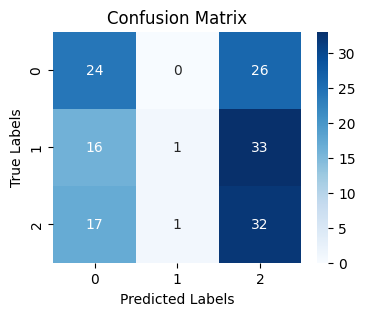

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Metrics before fine-tuning")
print("accuracy", accuracy.compute(predictions=predicted_labels, references=true_labels), "precision", precision.compute(predictions=predicted_labels, references=true_labels, average="micro"),
"recall", recall.compute(predictions=predicted_labels, references=true_labels, average="micro"), "f1", f1.compute(predictions=predicted_labels, references=true_labels, average="micro"))

Metrics before fine-tuning
accuracy {'accuracy': 0.38} precision {'precision': 0.38} recall {'recall': 0.38} f1 {'f1': 0.38}


<br>

# Finetuning the model for sentiment analysis using LORA

This model takes input as a combined string text + aspects

<br>

In [ ]:
def tokenize_function(examples):

    sentence = examples['text']

    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        sentence,
        return_tensors="np",
        truncation=True,
        max_length=150,
        padding="max_length"
    )
    return tokenized_inputs

In [ ]:
tokenized_dataset = combined_dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'snippets', 'target', 'sentiment_score', 'aspects', 'format', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 961
    })
    validation: Dataset({
        features: ['sentence', 'snippets', 'target', 'sentiment_score', 'aspects', 'format', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 102
    })
    test: Dataset({
        features: ['sentence', 'snippets', 'target', 'sentiment_score', 'aspects', 'format', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 150
    })
})

In [ ]:
tokenized_dataset.set_format(type="torch", columns=['label', 'input_ids', 'attention_mask'])

In [ ]:
# hyperparameters
lr = 1e-3
batch_size = 16
num_epochs = 3

In [ ]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ['q_lin'])

In [ ]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules={'q_lin'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [ ]:
model_combined = get_peft_model(model_combined, peft_config)
model_combined.print_trainable_parameters()

trainable params: 629,763 || all params: 67,585,542 || trainable%: 0.9318013607111414


In [ ]:
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/fin_opinion/" + model_checkpoint + "-lora-combined-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model_combined,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # model_init=model_init
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.348991,{'accuracy': 0.5882352941176471},{'precision': 0.5882352941176471},{'recall': 0.5882352941176471},{'f1': 0.5882352941176471}
2,No log,1.022274,{'accuracy': 0.6078431372549019},{'precision': 0.6078431372549019},{'recall': 0.6078431372549019},{'f1': 0.6078431372549019}
3,No log,1.053196,{'accuracy': 0.6372549019607843},{'precision': 0.6372549019607843},{'recall': 0.6372549019607843},{'f1': 0.6372549019607843}


Trainer is attempting to log a value of "{'accuracy': 0.5882352941176471}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.5882352941176471}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.5882352941176471}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.5882352941176471}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.6078431372549019}" of type <class 

TrainOutput(global_step=183, training_loss=0.45335409028934, metrics={'train_runtime': 31.21, 'train_samples_per_second': 92.374, 'train_steps_per_second': 5.864, 'total_flos': 113521835421000.0, 'train_loss': 0.45335409028934, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.815991,{'accuracy': 0.6568627450980392},{'precision': 0.6568627450980392},{'recall': 0.6568627450980392},{'f1': 0.6568627450980392}
2,No log,0.660614,{'accuracy': 0.7352941176470589},{'precision': 0.7352941176470589},{'recall': 0.7352941176470589},{'f1': 0.735294117647059}
3,No log,0.651525,{'accuracy': 0.7156862745098039},{'precision': 0.7156862745098039},{'recall': 0.7156862745098039},{'f1': 0.7156862745098039}


Trainer is attempting to log a value of "{'accuracy': 0.6568627450980392}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.6568627450980392}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.6568627450980392}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6568627450980392}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.7352941176470589}" of type <class 

TrainOutput(global_step=183, training_loss=0.2532475372481216, metrics={'train_runtime': 30.6193, 'train_samples_per_second': 94.156, 'train_steps_per_second': 5.977, 'total_flos': 113521835421000.0, 'train_loss': 0.2532475372481216, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.525970,{'accuracy': 0.803921568627451},{'precision': 0.803921568627451},{'recall': 0.803921568627451},{'f1': 0.8039215686274509}
2,No log,0.345472,{'accuracy': 0.8823529411764706},{'precision': 0.8823529411764706},{'recall': 0.8823529411764706},{'f1': 0.8823529411764706}
3,No log,0.374780,{'accuracy': 0.8529411764705882},{'precision': 0.8529411764705882},{'recall': 0.8529411764705882},{'f1': 0.8529411764705882}


Trainer is attempting to log a value of "{'accuracy': 0.803921568627451}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.803921568627451}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.803921568627451}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8039215686274509}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8823529411764706}" of type <class 'di

TrainOutput(global_step=183, training_loss=0.13811057252310666, metrics={'train_runtime': 30.6231, 'train_samples_per_second': 94.145, 'train_steps_per_second': 5.976, 'total_flos': 113521835421000.0, 'train_loss': 0.13811057252310666, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.449163,{'accuracy': 0.8235294117647058},{'precision': 0.8235294117647058},{'recall': 0.8235294117647058},{'f1': 0.8235294117647058}
2,No log,0.167279,{'accuracy': 0.9411764705882353},{'precision': 0.9411764705882353},{'recall': 0.9411764705882353},{'f1': 0.9411764705882353}
3,No log,0.095776,{'accuracy': 0.9705882352941176},{'precision': 0.9705882352941176},{'recall': 0.9705882352941176},{'f1': 0.9705882352941176}


Trainer is attempting to log a value of "{'accuracy': 0.8235294117647058}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8235294117647058}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.8235294117647058}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8235294117647058}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9411764705882353}" of type <class 

TrainOutput(global_step=183, training_loss=0.08233989653040151, metrics={'train_runtime': 30.5345, 'train_samples_per_second': 94.418, 'train_steps_per_second': 5.993, 'total_flos': 113521835421000.0, 'train_loss': 0.08233989653040151, 'epoch': 3.0})

In [ ]:
model_path = "/content/drive/MyDrive/fin_opinion/saved_model/model_combined_lora"
trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/fin_opinion/saved_model/model_combined_lora/tokenizer_config.json',
 '/content/drive/MyDrive/fin_opinion/saved_model/model_combined_lora/special_tokens_map.json',
 '/content/drive/MyDrive/fin_opinion/saved_model/model_combined_lora/vocab.txt',
 '/content/drive/MyDrive/fin_opinion/saved_model/model_combined_lora/added_tokens.json',
 '/content/drive/MyDrive/fin_opinion/saved_model/model_combined_lora/tokenizer.json')

## Evaluating the model for test dataset

In [ ]:
predicted_labels = []

for example in combined_dataset['test']:
    text = example['text']
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    logits = model_combined(inputs).logits
    predictions = torch.argmax(logits)

    predicted_labels.append(predictions.item())

predicted_labels

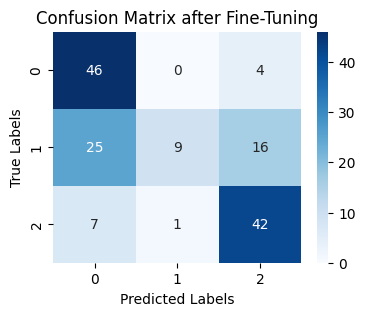

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix after Fine-Tuning')
plt.show()

In [ ]:
print("Metrics before fine-tuning")
print("accuracy", accuracy.compute(predictions=predicted_labels, references=true_labels), "precision", precision.compute(predictions=predicted_labels, references=true_labels, average="micro"),
"recall", recall.compute(predictions=predicted_labels, references=true_labels, average="micro"), "f1", f1.compute(predictions=predicted_labels, references=true_labels, average="micro"))

Metrics before fine-tuning
accuracy {'accuracy': 0.6466666666666666} precision {'precision': 0.6466666666666666} recall {'recall': 0.6466666666666666} f1 {'f1': 0.6466666666666666}


### This model achieves a higher accuracy compared to the previous one.

# Hyperparameter tuning

In [ ]:
# hyperparameters
lr = 1e-4
batch_size = 32
num_epochs = 6

In [ ]:
model_checkpoint = 'distilbert-base-uncased'

id2label = {0: "Positive", 1: "Neutral", 2: "Negative"}
label2id = {"Positive":0, "Neutral":1, "Negative":2}

model_combined_32_1e_4 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=3, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model_combined_32_1e_4.resize_token_embeddings(len(tokenizer))


In [ ]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda"
model_combined_32_1e_4.to(device)
model_combined_32_1e_4

In [ ]:
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/fin_opinion/" + model_checkpoint + "-lora-combined-text-classification-32-1e-4",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model_combined_32_1e_4,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # model_init=model_init
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.076800,{'accuracy': 0.6176470588235294},{'precision': 0.6176470588235294},{'recall': 0.6176470588235294},{'f1': 0.6176470588235294}
2,No log,0.996810,{'accuracy': 0.6274509803921569},{'precision': 0.6274509803921569},{'recall': 0.6274509803921569},{'f1': 0.6274509803921569}
3,No log,0.826019,{'accuracy': 0.696078431372549},{'precision': 0.696078431372549},{'recall': 0.696078431372549},{'f1': 0.696078431372549}
4,No log,0.627929,{'accuracy': 0.8235294117647058},{'precision': 0.8235294117647058},{'recall': 0.8235294117647058},{'f1': 0.8235294117647058}
5,No log,0.386976,{'accuracy': 0.8627450980392157},{'precision': 0.8627450980392157},{'recall': 0.8627450980392157},{'f1': 0.8627450980392157}
6,No log,0.327375,{'accuracy': 0.9019607843137255},{'precision': 0.9019607843137255},{'recall': 0.9019607843137255},{'f1': 0.9019607843137255}


Trainer is attempting to log a value of "{'accuracy': 0.6176470588235294}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.6176470588235294}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.6176470588235294}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6176470588235294}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.6274509803921569}" of type <class 

TrainOutput(global_step=186, training_loss=0.2552569194506573, metrics={'train_runtime': 113.2089, 'train_samples_per_second': 50.932, 'train_steps_per_second': 1.643, 'total_flos': 223775578729800.0, 'train_loss': 0.2552569194506573, 'epoch': 6.0})

In [ ]:
model_path = "/content/drive/MyDrive/fin_opinion/saved_model/model_hyper_32_1e-4"
trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/fin_opinion/saved_model/model_hyper_32_1e-4/tokenizer_config.json',
 '/content/drive/MyDrive/fin_opinion/saved_model/model_hyper_32_1e-4/special_tokens_map.json',
 '/content/drive/MyDrive/fin_opinion/saved_model/model_hyper_32_1e-4/vocab.txt',
 '/content/drive/MyDrive/fin_opinion/saved_model/model_hyper_32_1e-4/added_tokens.json',
 '/content/drive/MyDrive/fin_opinion/saved_model/model_hyper_32_1e-4/tokenizer.json')

In [ ]:
# hyperparameters set 2
lr = 2e-3
batch_size = 8
num_epochs = 3

In [ ]:
model_checkpoint = 'distilbert-base-uncased'

id2label = {0: "Positive", 1: "Neutral", 2: "Negative"}
label2id = {"Positive":0, "Neutral":1, "Negative":2}

model_combined_8_2e_3 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=3, id2label=id2label, label2id=label2id)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model_combined_8_2e_3.resize_token_embeddings(len(tokenizer))


In [ ]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda"
model_combined_8_2e_3.to(device)
model_combined_8_2e_3

In [ ]:
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/fin_opinion/" + model_checkpoint + "-lora-combined-text-classification-8-2e-3",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model_combined_8_2e_3,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # model_init=model_init
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,2.358062,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}
2,No log,1.631721,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}
3,No log,1.963138,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}


Trainer is attempting to log a value of "{'accuracy': 0.3333333333333333}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.3333333333333333}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.3333333333333333}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.3333333333333333}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.3333333333333333}" of type <class 

TrainOutput(global_step=363, training_loss=0.8114634111893079, metrics={'train_runtime': 65.1746, 'train_samples_per_second': 44.235, 'train_steps_per_second': 5.57, 'total_flos': 111887789364900.0, 'train_loss': 0.8114634111893079, 'epoch': 3.0})


# Conclusion

**Best accuracy model for combined input:**

accuracy {'accuracy': 0.6466666666666666} precision {'precision': 0.6466666666666666} recall {'recall': 0.6466666666666666} f1 {'f1': 0.6466666666666666}

<br>

# Fine-tuning FinBERT for combined input and using LoRA.


**Model:** finbert (huggingface)

Why FinBERT?

FinBERT used BERT as a base model and is trained on large corpus of financial text data. This can prove essential for improving the accuracy of Sentiment Analysis task.'


**Metric:**

The metrics used for evaluating the model are **Accuracy, Precision, Recall, f1 score and confusion matrix**. These are some standard metric to judge the performance of a classifier.
These help in understanding the classifier's behaviour and how well it performs in classifying the text.


<br>


## Model

In [ ]:
id2label = {0: "Positive", 1: "Neutral", 2: "Negative"}
label2id = {"Positive":0, "Neutral":1, "Negative":2}

model_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain',num_labels=3, id2label=id2label, label2id=label2id)
tokenizer_finbert = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

In [ ]:
if tokenizer_finbert.pad_token is None:
    tokenizer_finbert.add_special_tokens({'pad_token': '[PAD]'})
    model_finbert.resize_token_embeddings(len(tokenizer_finbert))

In [ ]:
def tokenize_function(examples):

    sentence = examples['text']

    tokenizer_finbert.truncation_side = "left"
    tokenized_inputs = tokenizer_finbert(
        sentence,
        return_tensors="np",
        truncation=True,
        max_length=150,
        padding="max_length"
    )

    return tokenized_inputs

In [ ]:
tokenized_dataset_finbert = combined_dataset.map(tokenize_function, batched=True)
tokenized_dataset_finbert.set_format(type="torch", columns=['label', 'input_ids', 'attention_mask'])

In [ ]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda"
model_finbert.to(device)
model_finbert

### Evaluating model before fine-tuning

In [ ]:
predicted_labels = []

for example in combined_dataset['test']:
    text = example['text']
    inputs = tokenizer_finbert.encode(text, return_tensors="pt").to(device)

    logits = model_finbert(inputs).logits
    predictions = torch.argmax(logits)
    predicted_labels.append(predictions.item())

predicted_labels

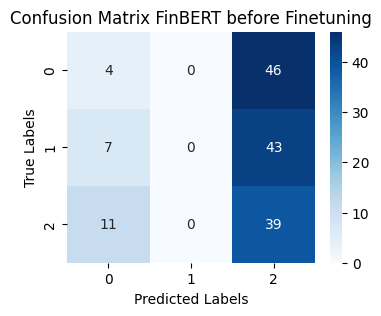

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix FinBERT before Finetuning')
plt.show()

In [ ]:
print("Metrics for FinBERT before fine-tuning")
print("accuracy", accuracy.compute(predictions=predicted_labels, references=true_labels), "precision", precision.compute(predictions=predicted_labels, references=true_labels, average="micro"),
"recall", recall.compute(predictions=predicted_labels, references=true_labels, average="micro"), "f1", f1.compute(predictions=predicted_labels, references=true_labels, average="micro"))

Metrics for FinBERT before fine-tuning
accuracy {'accuracy': 0.2866666666666667} precision {'precision': 0.2866666666666667} recall {'recall': 0.2866666666666667} f1 {'f1': 0.2866666666666667}


## Finetuning FinBERT using LoRA

In [ ]:
# hyperparameters
lr = 1e-4
batch_size = 32
num_epochs = 3

In [ ]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        )

In [ ]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules=None, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [ ]:
model_finbert = get_peft_model(model_finbert, peft_config)
model_finbert.print_trainable_parameters()

trainable params: 149,763 || all params: 109,903,878 || trainable%: 0.13626725710261106


In [ ]:
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/fin_opinion/" + model_checkpoint + "-lora-combined-text-classification-finbert",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model_finbert,
    args=training_args,
    train_dataset=tokenized_dataset_finbert["train"],
    eval_dataset=tokenized_dataset_finbert["validation"],
    tokenizer=tokenizer_finbert,
    compute_metrics=compute_metrics,
    # model_init=model_init
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.658419,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}
2,No log,1.668650,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}
3,No log,1.658042,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}


Trainer is attempting to log a value of "{'accuracy': 0.3333333333333333}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.3333333333333333}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.3333333333333333}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.3333333333333333}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.3333333333333333}" of type <class 

TrainOutput(global_step=93, training_loss=0.7530887562741515, metrics={'train_runtime': 60.1837, 'train_samples_per_second': 47.903, 'train_steps_per_second': 1.545, 'total_flos': 222621788291400.0, 'train_loss': 0.7530887562741515, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.259528,{'accuracy': 0.6176470588235294},{'precision': 0.6176470588235294},{'recall': 0.6176470588235294},{'f1': 0.6176470588235294}
2,No log,0.825633,{'accuracy': 0.6176470588235294},{'precision': 0.6176470588235294},{'recall': 0.6176470588235294},{'f1': 0.6176470588235294}
3,No log,0.831585,{'accuracy': 0.6764705882352942},{'precision': 0.6764705882352942},{'recall': 0.6764705882352942},{'f1': 0.6764705882352942}


Trainer is attempting to log a value of "{'accuracy': 0.6176470588235294}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.6176470588235294}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.6176470588235294}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6176470588235294}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.6176470588235294}" of type <class 

TrainOutput(global_step=183, training_loss=0.3783543487715591, metrics={'train_runtime': 60.5459, 'train_samples_per_second': 47.617, 'train_steps_per_second': 3.023, 'total_flos': 222621788291400.0, 'train_loss': 0.3783543487715591, 'epoch': 3.0})

## Changing Hyperparameters

In [ ]:
# hyperparameters
lr = 1e-2
batch_size = 24
num_epochs = 3

In [ ]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        )

In [ ]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules=None, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [ ]:
model_finbert = get_peft_model(model_finbert, peft_config)
model_finbert.print_trainable_parameters()

trainable params: 149,763 || all params: 109,903,878 || trainable%: 0.13626725710261106


In [ ]:
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/fin_opinion/" + model_checkpoint + "-lora-combined-text-classification-finbert_24",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model_finbert,
    args=training_args,
    train_dataset=tokenized_dataset_finbert["train"],
    eval_dataset=tokenized_dataset_finbert["validation"],
    tokenizer=tokenizer_finbert,
    compute_metrics=compute_metrics,
    # model_init=model_init
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,6.078864,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}
2,No log,2.009087,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}
3,No log,1.483157,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}


Trainer is attempting to log a value of "{'accuracy': 0.3333333333333333}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.3333333333333333}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.3333333333333333}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.3333333333333333}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.3333333333333333}" of type <class 

TrainOutput(global_step=123, training_loss=1.6564367030694234, metrics={'train_runtime': 56.7368, 'train_samples_per_second': 50.814, 'train_steps_per_second': 2.168, 'total_flos': 222621788291400.0, 'train_loss': 1.6564367030694234, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,3.146753,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}
2,No log,1.502867,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}
3,No log,1.514410,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}


Trainer is attempting to log a value of "{'accuracy': 0.3333333333333333}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.3333333333333333}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.3333333333333333}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.3333333333333333}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.3333333333333333}" of type <class 

TrainOutput(global_step=123, training_loss=0.9621505117028709, metrics={'train_runtime': 56.954, 'train_samples_per_second': 50.62, 'train_steps_per_second': 2.16, 'total_flos': 222621788291400.0, 'train_loss': 0.9621505117028709, 'epoch': 3.0})

### No satisfactory results. Trying some different hyperparameters.

In [ ]:
# hyperparameters
lr = 1e-5
batch_size = 32
num_epochs = 3

In [ ]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        )

In [ ]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules=None, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [ ]:
model_finbert = get_peft_model(model_finbert, peft_config)
model_finbert.print_trainable_parameters()

trainable params: 149,763 || all params: 109,903,878 || trainable%: 0.13626725710261106


In [ ]:
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/fin_opinion/" + model_checkpoint + "-lora-combined-text-classification-finbert_1e-5_32",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model_finbert,
    args=training_args,
    train_dataset=tokenized_dataset_finbert["train"],
    eval_dataset=tokenized_dataset_finbert["validation"],
    tokenizer=tokenizer_finbert,
    compute_metrics=compute_metrics,
    # model_init=model_init
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,6.078864,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}
2,No log,2.009087,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}
3,No log,1.483157,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}


Trainer is attempting to log a value of "{'accuracy': 0.3333333333333333}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.3333333333333333}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.3333333333333333}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.3333333333333333}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.3333333333333333}" of type <class 

TrainOutput(global_step=123, training_loss=1.6564367030694234, metrics={'train_runtime': 56.7368, 'train_samples_per_second': 50.814, 'train_steps_per_second': 2.168, 'total_flos': 222621788291400.0, 'train_loss': 1.6564367030694234, 'epoch': 3.0})

Model still performs poorly.


## Fine-tuning without LORA

Since the dataset is small and LoRA reduces the parameters which might effect the context understanding of the model. Investigate if model performs better without LoRA.

<br>

In [ ]:
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/fin_opinion/" + model_checkpoint + "-combined-text-classification-finbert",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model_finbert,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer_finbert,
    compute_metrics=compute_metrics,
    # model_init=model_init
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.877600,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}
2,No log,1.646443,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}
3,No log,1.909897,{'accuracy': 0.3333333333333333},{'precision': 0.3333333333333333},{'recall': 0.3333333333333333},{'f1': 0.3333333333333333}


Trainer is attempting to log a value of "{'accuracy': 0.3333333333333333}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.3333333333333333}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.3333333333333333}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.3333333333333333}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.3333333333333333}" of type <class 

TrainOutput(global_step=183, training_loss=0.8339942973819586, metrics={'train_runtime': 179.8216, 'train_samples_per_second': 16.033, 'train_steps_per_second': 1.018, 'total_flos': 222233198235300.0, 'train_loss': 0.8339942973819586, 'epoch': 3.0})

## Conclusion:

#### Surprisingly,  FinBERT yielded unsatisfactory results for this particular task. BERT, on the other hand, outperformed FinBERT, demonstrating better performance.


<br>

# **Task 2**


---



<br>

# **Model for Detecting Aspects by finetuning distilbert-base-uncased and using LoRA**

**Model:** 'distilbert-base-uncased'

DistilBERT is a smaller and faster version of BERT, designed to be more computationally efficient while retaining much of the performance of the original BERT model. Despite of being smaller than BERT it has shown comparable performance. DistilBERT is trained on large corpus of text data, since this task is understanding and classifying text, I chose DistilBERT for this task.

**Metric:**

The metrics used for evaluating the model are **Accuracy, Precision, Recall, f1 score and confusion matrix**. These are some standard metric to judge the performance of a classifier.
These help in understanding the classifier's behaviour and how well it performs in classifying the text.

**Desciption:**

There are text instance in the financial domain, for this task we need to classify these sentences into aspect categories.

There are 125 aspect categories in the train dataset.

**Training:**

Used the distilbert-base-uncased model which will classify the text into either one of the 125 classes. The code below explains:

* Preprocessing the data and restructuring the dataset.
* Evaluate performance of model before fine-tuning.
* Tokenizing the text and getting the embeddings. Converting them into tensors.
* Configuring LoRA for parameter efficient fine-tuning and making the training faster with lesser parameters while maintaining efficiency.
* Using Trainer() class from huggingface to train the model.
* Evaluate performance of model after fine-tuning.
* Hyperparameter tuning.

**Performance:**

**Before fine-tuning:**

accuracy {'accuracy': 0.36666666666666664} precision {'precision': 0.36666666666666664} recall {'recall': 0.36666666666666664} f1 {'f1': 0.36666666666666664}

**Best model after fine-tuning:**

accuracy {'accuracy': 0.41333333333333333} precision {'precision': 0.41333333333333333} recall {'recall': 0.41333333333333333} f1 {'f1': 0.41333333333333333}
<br>


--

## An approach to make the labels less complex:

Since the dataset is small and there are more number of classes (125), the model is not able to capture the relationship and hence the performance is not that great.

To tackle with this issue I made the labels less complex. The aspects in the dataset has upto 6 levels. I reduce them and use only first 2 levels for solving this classification task.

Now there are 28 different aspect categories to classify the text into.

**Best Accuracy with 125 classes:**

accuracy {'accuracy': 0.41333333333333333} precision {'precision': 0.41333333333333333} recall {'recall': 0.41333333333333333} f1 {'f1': 0.41333333333333333}

**Best Accuracy with 28 classed:**

accuracy {'accuracy': 0.6733333333333333} precision {'precision': 0.6733333333333333} recall {'recall': 0.6733333333333333} f1 {'f1': 0.6733333333333333}




<br>


In [ ]:
aspects = list(train_dataset_df['aspects'].unique()) + list(test_dataset_df['aspects'].unique()) + list(validation_dataset_df['aspects'].unique())
aspects = list(set(aspects))

In [ ]:
for i, text in enumerate(aspects):
  aspects[i] = re.sub(r'[^a-zA-Z0-9\s\/]+', '', text)

In [ ]:
aspects = ["/".join(item.split("/")[:2]) for item in aspects]
aspects = list(set(aspects))
aspects_id2l = {i: value for i, value in enumerate(aspects)}
aspects_l2id = {value: i for i, value in enumerate(aspects)}

## Fine-tuning DistilBERT for aspect classification and using LoRA.

In [ ]:
model_checkpoint = 'distilbert-base-uncased'

id2label = aspects_id2l
label2id = aspects_l2id

model_aspect_bert = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=130, id2label=id2label, label2id=label2id)

In [ ]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda"
model_aspect_bert.to(device)
model_aspect_bert

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model_aspect_bert.resize_token_embeddings(len(tokenizer))


In [ ]:
def tokenize_function(examples):

    sentence = examples['sentence']

    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        sentence,
        return_tensors="np",
        truncation=True,
        max_length=150,
        padding="max_length"
    )

    return tokenized_inputs

In [ ]:
tokenized_dataset_aspect = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

In [ ]:
replace_aspects = []
# for i, text in enumerate(tokenized_dataset_aspect['train']['aspects']):
#   text = re.sub(r'[^a-zA-Z0-9\s]+', '', text)
#   text = aspects_l2id[text]
#   replace_aspects.append(text)

# for i, text in enumerate(tokenized_dataset_aspect['test']['aspects']):
#   text = re.sub(r'[^a-zA-Z0-9\s]+', '', text)
#   text = aspects_l2id[text]
#   replace_aspects.append(text)

for i, text in enumerate(tokenized_dataset_aspect['validation']['aspects']):
  text = re.sub(r'[^a-zA-Z0-9\s]+', '', text)
  text = aspects_l2id[text]
  replace_aspects.append(text)
print(replace_aspects)

[78, 117, 112, 52, 30, 65, 43, 46, 128, 32, 20, 105, 73, 125, 77, 32, 87, 37, 4, 128, 95, 16, 87, 54, 46, 117, 83, 83, 106, 105, 95, 112, 84, 72, 30, 46, 29, 77, 77, 19, 128, 65, 87, 30, 77, 30, 87, 125, 72, 112, 47, 47, 30, 30, 112, 78, 108, 87, 112, 59, 0, 13, 32, 125, 36, 128, 19, 46, 46, 103, 128, 16, 95, 32, 21, 128, 53, 128, 5, 37, 30, 20, 39, 95, 5, 2, 28, 29, 125, 42, 126, 129, 47, 42, 19, 117, 32, 52, 36, 117, 36, 29]


In [ ]:
tokenized_dataset_aspect['validation']=tokenized_dataset_aspect['validation'].add_column('labels',replace_aspects)
tokenized_dataset_aspect.set_format(type="torch", columns=['sentence', 'labels', 'input_ids', 'attention_mask'])

In [ ]:
true_labels = tokenized_dataset_aspect['test']['labels']
predicted_labels = []

for example in tokenized_dataset_aspect['test']:
    text = example['sentence']
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    logits = model_aspect_bert(inputs).logits
    predictions = torch.argmax(logits)
    predicted_labels.append(predictions.item())

predicted_labels

In [ ]:
print("Metrics after fine-tuning for aspects")
print("accuracy", accuracy.compute(predictions=predicted_labels, references=true_labels), "precision", precision.compute(predictions=predicted_labels, references=true_labels, average="micro"),
"recall", recall.compute(predictions=predicted_labels, references=true_labels, average="micro"), "f1", f1.compute(predictions=predicted_labels, references=true_labels, average="micro"))

In [ ]:
# hyperparameters
lr = 1e-3
batch_size = 16
num_epochs = 3

In [ ]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ['q_lin'])

In [ ]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules={'q_lin'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [ ]:
model_aspect_bert = get_peft_model(model_aspect_bert, peft_config)
model_aspect_bert.print_trainable_parameters()

trainable params: 727,426 || all params: 67,780,868 || trainable%: 1.0732025444112046


In [ ]:
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/fin_opinion/" + model_checkpoint + "-lora-aspects-text-classification-bert",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model_aspect_bert,
    args=training_args,
    train_dataset=tokenized_dataset_aspect["train"],
    eval_dataset=tokenized_dataset_aspect["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # model_init=model_init
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,3.571045,{'accuracy': 0.22549019607843138},{'precision': 0.22549019607843138},{'recall': 0.22549019607843138},{'f1': 0.22549019607843138}
2,No log,3.034300,{'accuracy': 0.3431372549019608},{'precision': 0.3431372549019608},{'recall': 0.3431372549019608},{'f1': 0.3431372549019608}
3,No log,2.859828,{'accuracy': 0.38235294117647056},{'precision': 0.38235294117647056},{'recall': 0.38235294117647056},{'f1': 0.3823529411764706}


Trainer is attempting to log a value of "{'accuracy': 0.22549019607843138}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.22549019607843138}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.22549019607843138}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.22549019607843138}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.3431372549019608}" of type <cl

TrainOutput(global_step=183, training_loss=3.3086694602757856, metrics={'train_runtime': 29.7736, 'train_samples_per_second': 96.831, 'train_steps_per_second': 6.146, 'total_flos': 114028647793200.0, 'train_loss': 3.3086694602757856, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,2.244744,{'accuracy': 0.46078431372549017},{'precision': 0.46078431372549017},{'recall': 0.46078431372549017},{'f1': 0.46078431372549017}
2,No log,1.834696,{'accuracy': 0.5490196078431373},{'precision': 0.5490196078431373},{'recall': 0.5490196078431373},{'f1': 0.5490196078431373}
3,No log,1.687990,{'accuracy': 0.5392156862745098},{'precision': 0.5392156862745098},{'recall': 0.5392156862745098},{'f1': 0.5392156862745098}


Trainer is attempting to log a value of "{'accuracy': 0.46078431372549017}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.46078431372549017}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.46078431372549017}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.46078431372549017}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.5490196078431373}" of type <cl

TrainOutput(global_step=183, training_loss=2.1922475679324624, metrics={'train_runtime': 31.5829, 'train_samples_per_second': 91.284, 'train_steps_per_second': 5.794, 'total_flos': 114028647793200.0, 'train_loss': 2.1922475679324624, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.308286,{'accuracy': 0.6764705882352942},{'precision': 0.6764705882352942},{'recall': 0.6764705882352942},{'f1': 0.6764705882352942}
2,No log,0.896369,{'accuracy': 0.7745098039215687},{'precision': 0.7745098039215687},{'recall': 0.7745098039215687},{'f1': 0.7745098039215687}
3,No log,0.750139,{'accuracy': 0.7843137254901961},{'precision': 0.7843137254901961},{'recall': 0.7843137254901961},{'f1': 0.7843137254901961}


Trainer is attempting to log a value of "{'accuracy': 0.6764705882352942}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.6764705882352942}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.6764705882352942}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6764705882352942}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.7745098039215687}" of type <class 

TrainOutput(global_step=183, training_loss=1.3833205426325563, metrics={'train_runtime': 30.407, 'train_samples_per_second': 94.814, 'train_steps_per_second': 6.018, 'total_flos': 114028647793200.0, 'train_loss': 1.3833205426325563, 'epoch': 3.0})

## Checkpoint model Accuracy

In [ ]:
predicted_labels = []

for example in tokenized_dataset_aspect['test']:
    text = example['sentence']
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    logits = model_aspect_bert(inputs).logits
    predictions = torch.argmax(logits)

    predicted_labels.append(predictions.item())

predicted_labels

In [ ]:
print("Metrics after fine-tuning for aspects")
print("accuracy", accuracy.compute(predictions=predicted_labels, references=true_labels), "precision", precision.compute(predictions=predicted_labels, references=true_labels, average="micro"),
"recall", recall.compute(predictions=predicted_labels, references=true_labels, average="micro"), "f1", f1.compute(predictions=predicted_labels, references=true_labels, average="micro"))

Metrics after fine-tuning for aspects
accuracy {'accuracy': 0.4066666666666667} precision {'precision': 0.4066666666666667} recall {'recall': 0.4066666666666667} f1 {'f1': 0.4066666666666667}


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.537705,{'accuracy': 0.9019607843137255},{'precision': 0.9019607843137255},{'recall': 0.9019607843137255},{'f1': 0.9019607843137255}
2,No log,0.316621,{'accuracy': 0.9215686274509803},{'precision': 0.9215686274509803},{'recall': 0.9215686274509803},{'f1': 0.9215686274509803}
3,No log,0.223561,{'accuracy': 0.9705882352941176},{'precision': 0.9705882352941176},{'recall': 0.9705882352941176},{'f1': 0.9705882352941176}


Trainer is attempting to log a value of "{'accuracy': 0.9019607843137255}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9019607843137255}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9019607843137255}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9019607843137255}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9215686274509803}" of type <class 

TrainOutput(global_step=183, training_loss=0.8158733597218665, metrics={'train_runtime': 31.0991, 'train_samples_per_second': 92.704, 'train_steps_per_second': 5.884, 'total_flos': 114028647793200.0, 'train_loss': 0.8158733597218665, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.178066,{'accuracy': 0.9705882352941176},{'precision': 0.9705882352941176},{'recall': 0.9705882352941176},{'f1': 0.9705882352941176}
2,No log,0.123535,{'accuracy': 0.9705882352941176},{'precision': 0.9705882352941176},{'recall': 0.9705882352941176},{'f1': 0.9705882352941176}
3,No log,0.080711,{'accuracy': 0.9901960784313726},{'precision': 0.9901960784313726},{'recall': 0.9901960784313726},{'f1': 0.9901960784313726}


Trainer is attempting to log a value of "{'accuracy': 0.9705882352941176}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9705882352941176}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9705882352941176}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9705882352941176}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9705882352941176}" of type <class 

TrainOutput(global_step=183, training_loss=0.4806039528768571, metrics={'train_runtime': 32.4033, 'train_samples_per_second': 88.973, 'train_steps_per_second': 5.648, 'total_flos': 114028647793200.0, 'train_loss': 0.4806039528768571, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.086257,{'accuracy': 0.9803921568627451},{'precision': 0.9803921568627451},{'recall': 0.9803921568627451},{'f1': 0.9803921568627451}
2,No log,0.060045,{'accuracy': 0.9901960784313726},{'precision': 0.9901960784313726},{'recall': 0.9901960784313726},{'f1': 0.9901960784313726}
3,No log,0.033416,{'accuracy': 0.9901960784313726},{'precision': 0.9901960784313726},{'recall': 0.9901960784313726},{'f1': 0.9901960784313726}


Trainer is attempting to log a value of "{'accuracy': 0.9803921568627451}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9803921568627451}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9803921568627451}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9803921568627451}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9901960784313726}" of type <class 

TrainOutput(global_step=183, training_loss=0.29004727556405824, metrics={'train_runtime': 30.4629, 'train_samples_per_second': 94.64, 'train_steps_per_second': 6.007, 'total_flos': 114028647793200.0, 'train_loss': 0.29004727556405824, 'epoch': 3.0})

In [ ]:
predicted_labels = []

for example in tokenized_dataset_aspect['test']:
    text = example['sentence']
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    logits = model_aspect_bert(inputs).logits
    predictions = torch.argmax(logits)

    predicted_labels.append(predictions.item())

predicted_labels

In [ ]:
print("Metrics after fine-tuning for aspects")
print("accuracy", accuracy.compute(predictions=predicted_labels, references=true_labels), "precision", precision.compute(predictions=predicted_labels, references=true_labels, average="micro"),
"recall", recall.compute(predictions=predicted_labels, references=true_labels, average="micro"), "f1", f1.compute(predictions=predicted_labels, references=true_labels, average="micro"))

Metrics after fine-tuning for aspects
accuracy {'accuracy': 0.41333333333333333} precision {'precision': 0.41333333333333333} recall {'recall': 0.41333333333333333} f1 {'f1': 0.41333333333333333}


<br>

# An approach to make the labels less complex and improve accuracy.

Since the dataset is small and there are more number of classes (125), the model is not able to capture the relationship and hence the performance is not that great.

To tackle with this issue I made the labels less complex. The aspects in the dataset has upto 6 levels. I reduce them and use only first 2 levels for solving this classification task.

Now there are 28 different aspect categories to classify the text into.

Finetuning the distilBERT model and using **LoRA**.

**Model:** distilbert-base-uncased

**Metrics:** Accuracy, Precision, Recall, F1 score, Confusion matrix.

**Best Accuracy with 125 classes:**

accuracy {'accuracy': 0.41333333333333333} precision {'precision': 0.41333333333333333} recall {'recall': 0.41333333333333333} f1 {'f1': 0.41333333333333333}

**Best Accuracy with 28 classed:**

accuracy {'accuracy': 0.6733333333333333} precision {'precision': 0.6733333333333333} recall {'recall': 0.6733333333333333} f1 {'f1': 0.6733333333333333}

<br>




In [ ]:
model_checkpoint = 'distilbert-base-uncased'

id2label = aspects_id2l
label2id = aspects_l2id

model_aspect_bert2 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=28, id2label=id2label, label2id=label2id)

In [ ]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda"
model_aspect_bert2.to(device)
model_aspect_bert2

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model_aspect_bert2.resize_token_embeddings(len(tokenizer))


In [ ]:
def tokenize_function(examples):

    sentence = examples['sentence']

    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        sentence,
        return_tensors="np",
        truncation=True,
        max_length=150,
        padding="max_length"
    )

    return tokenized_inputs

In [ ]:
tokenized_dataset_aspect = dataset.map(tokenize_function, batched=True)

<br>

## Encoding the aspects using tokenizer and adding it to the dataset as labels for training.

In [ ]:
replace_aspects = []
# for i, text in enumerate(tokenized_dataset_aspect['train']['aspects']):
#   text = re.sub(r'[^a-zA-Z0-9\s\/]+', '', text)
#   aspects = "/".join(text.split("/")[:2])
#   text = aspects_l2id[aspects]
#   replace_aspects.append(text)

for i, text in enumerate(tokenized_dataset_aspect['test']['aspects']):
  text = re.sub(r'[^a-zA-Z0-9\s\/]+', '', text)
  aspects = "/".join(text.split("/")[:2])
  text = aspects_l2id[aspects]
  replace_aspects.append(text)

# for i, text in enumerate(tokenized_dataset_aspect['validation']['aspects']):
#   text = re.sub(r'[^a-zA-Z0-9\s\/]+', '', text)
#   aspects = "/".join(text.split("/")[:2])
#   text = aspects_l2id[aspects]
#   replace_aspects.append(text)
print(replace_aspects)

[20, 1, 23, 19, 12, 20, 1, 1, 19, 20, 2, 2, 1, 4, 13, 24, 1, 11, 12, 21, 24, 24, 2, 13, 2, 11, 2, 13, 19, 2, 13, 2, 2, 2, 2, 6, 13, 4, 1, 2, 2, 6, 13, 10, 2, 7, 1, 19, 1, 2, 2, 14, 2, 13, 13, 24, 7, 7, 10, 20, 2, 14, 2, 1, 6, 2, 19, 7, 21, 21, 20, 2, 2, 6, 9, 4, 6, 2, 2, 24, 13, 2, 15, 2, 2, 20, 2, 21, 13, 7, 20, 20, 13, 13, 19, 18, 10, 13, 13, 2, 15, 2, 2, 19, 1, 2, 8, 2, 2, 24, 5, 2, 19, 2, 7, 3, 2, 2, 2, 4, 2, 2, 4, 19, 2, 2, 21, 24, 2, 19, 13, 2, 13, 2, 7, 6, 2, 2, 2, 24, 24, 5, 1, 25, 2, 15, 4, 13, 2, 20]


In [ ]:
tokenized_dataset_aspect['test']=tokenized_dataset_aspect['test'].add_column('labels',replace_aspects)
tokenized_dataset_aspect.set_format(type="torch", columns=['sentence', 'labels', 'input_ids', 'attention_mask'])

In [ ]:
# hyperparameters
lr = 1e-3
batch_size = 16
num_epochs = 3

In [ ]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ['q_lin'])

In [ ]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules={'q_lin'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [ ]:
model_aspect_bert2 = get_peft_model(model_aspect_bert2, peft_config)
model_aspect_bert2.print_trainable_parameters()

trainable params: 648,988 || all params: 67,623,992 || trainable%: 0.9597008115108022


In [ ]:
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/fin_opinion/" + model_checkpoint + "-lora-aspects-text-classification-bert-reduced",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model_aspect_bert2,
    args=training_args,
    train_dataset=tokenized_dataset_aspect["train"],
    eval_dataset=tokenized_dataset_aspect["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # model_init=model_init
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,2.152242,{'accuracy': 0.37254901960784315},{'precision': 0.37254901960784315},{'recall': 0.37254901960784315},{'f1': 0.37254901960784315}
2,No log,1.676429,{'accuracy': 0.5392156862745098},{'precision': 0.5392156862745098},{'recall': 0.5392156862745098},{'f1': 0.5392156862745098}
3,No log,1.531757,{'accuracy': 0.5882352941176471},{'precision': 0.5882352941176471},{'recall': 0.5882352941176471},{'f1': 0.5882352941176471}


Trainer is attempting to log a value of "{'accuracy': 0.37254901960784315}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.37254901960784315}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.37254901960784315}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.37254901960784315}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.5392156862745098}" of type <cl

TrainOutput(global_step=183, training_loss=1.7634625877838968, metrics={'train_runtime': 27.9218, 'train_samples_per_second': 103.253, 'train_steps_per_second': 6.554, 'total_flos': 113621601636000.0, 'train_loss': 1.7634625877838968, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.120253,{'accuracy': 0.696078431372549},{'precision': 0.696078431372549},{'recall': 0.696078431372549},{'f1': 0.696078431372549}
2,No log,0.792682,{'accuracy': 0.803921568627451},{'precision': 0.803921568627451},{'recall': 0.803921568627451},{'f1': 0.8039215686274509}
3,No log,0.718716,{'accuracy': 0.7745098039215687},{'precision': 0.7745098039215687},{'recall': 0.7745098039215687},{'f1': 0.7745098039215687}


Trainer is attempting to log a value of "{'accuracy': 0.696078431372549}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.696078431372549}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.696078431372549}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.696078431372549}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.803921568627451}" of type <class 'dict

TrainOutput(global_step=183, training_loss=0.9888695055018357, metrics={'train_runtime': 28.6341, 'train_samples_per_second': 100.684, 'train_steps_per_second': 6.391, 'total_flos': 113621601636000.0, 'train_loss': 0.9888695055018357, 'epoch': 3.0})

### Checkpoint Accuracy

In [ ]:
predicted_labels = []

for example in tokenized_dataset_aspect['test']:
    text = example['sentence']
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    logits = model_aspect_bert2(inputs).logits
    predictions = torch.argmax(logits)
    predicted_labels.append(predictions.item())

predicted_labels

In [ ]:
print("Metrics after fine-tuning for aspects - reduced complexity")
print("accuracy", accuracy.compute(predictions=predicted_labels, references=true_labels), "precision", precision.compute(predictions=predicted_labels, references=true_labels, average="micro"),
"recall", recall.compute(predictions=predicted_labels, references=true_labels, average="micro"), "f1", f1.compute(predictions=predicted_labels, references=true_labels, average="micro"))

Metrics after fine-tuning for aspects - reduced complexity
accuracy {'accuracy': 0.6666666666666666} precision {'precision': 0.6666666666666666} recall {'recall': 0.6666666666666666} f1 {'f1': 0.6666666666666666}


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.610716,{'accuracy': 0.8431372549019608},{'precision': 0.8431372549019608},{'recall': 0.8431372549019608},{'f1': 0.8431372549019607}
2,No log,0.424432,{'accuracy': 0.8823529411764706},{'precision': 0.8823529411764706},{'recall': 0.8823529411764706},{'f1': 0.8823529411764706}
3,No log,0.382009,{'accuracy': 0.9019607843137255},{'precision': 0.9019607843137255},{'recall': 0.9019607843137255},{'f1': 0.9019607843137255}


Trainer is attempting to log a value of "{'accuracy': 0.8431372549019608}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8431372549019608}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.8431372549019608}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8431372549019607}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8823529411764706}" of type <class 

TrainOutput(global_step=183, training_loss=0.6058538468157659, metrics={'train_runtime': 29.405, 'train_samples_per_second': 98.044, 'train_steps_per_second': 6.223, 'total_flos': 113621601636000.0, 'train_loss': 0.6058538468157659, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.293981,{'accuracy': 0.9313725490196079},{'precision': 0.9313725490196079},{'recall': 0.9313725490196079},{'f1': 0.9313725490196079}
2,No log,0.182152,{'accuracy': 0.9607843137254902},{'precision': 0.9607843137254902},{'recall': 0.9607843137254902},{'f1': 0.9607843137254902}
3,No log,0.160460,{'accuracy': 0.9803921568627451},{'precision': 0.9803921568627451},{'recall': 0.9803921568627451},{'f1': 0.9803921568627451}


Trainer is attempting to log a value of "{'accuracy': 0.9313725490196079}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9313725490196079}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9313725490196079}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9313725490196079}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9607843137254902}" of type <class 

TrainOutput(global_step=183, training_loss=0.37552659498537827, metrics={'train_runtime': 29.0003, 'train_samples_per_second': 99.413, 'train_steps_per_second': 6.31, 'total_flos': 113621601636000.0, 'train_loss': 0.37552659498537827, 'epoch': 3.0})

In [ ]:
predicted_labels = []

for example in tokenized_dataset_aspect['test']:
    text = example['sentence']
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    logits = model_aspect_bert2(inputs).logits
    predictions = torch.argmax(logits)

    predicted_labels.append(predictions.item())

predicted_labels

In [ ]:
print("Metrics after fine-tuning for aspects - reduced complexity")
print("accuracy", accuracy.compute(predictions=predicted_labels, references=true_labels), "precision", precision.compute(predictions=predicted_labels, references=true_labels, average="micro"),
"recall", recall.compute(predictions=predicted_labels, references=true_labels, average="micro"), "f1", f1.compute(predictions=predicted_labels, references=true_labels, average="micro"))

Metrics after fine-tuning for aspects - reduced complexity
accuracy {'accuracy': 0.6733333333333333} precision {'precision': 0.6733333333333333} recall {'recall': 0.6733333333333333} f1 {'f1': 0.6733333333333333}


# Model FinBERT for aspect classification.

FinBERT did not perform well for this task.

**Best Accuracy for finbert:**

accuracy {'accuracy': 0.04} precision {'precision': 0.04} recall {'recall': 0.04} f1 {'f1': 0.04}

In [ ]:
id2label = aspects_id2l
label2id = aspects_l2id

model_aspect = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain',num_labels=130, id2label=id2label, label2id=label2id)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda"
model_aspect.to(device)
model_aspect

In [ ]:
lr = 1e-3
batch_size = 16
num_epochs = 3

In [ ]:
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

In [ ]:
true_labels = tokenized_dataset_aspect['test']['labels']

In [ ]:
predicted_labels = []

for example in tokenized_dataset_aspect['test']:
    text = example['sentence']
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    logits = model_aspect(inputs).logits
    predictions = torch.argmax(logits)

    predicted_labels.append(predictions.item())

predicted_labels

In [ ]:
print("Metrics before fine-tuning for Aspects")
print("accuracy", accuracy.compute(predictions=predicted_labels, references=true_labels), "precision", precision.compute(predictions=predicted_labels, references=true_labels, average="micro"),
"recall", recall.compute(predictions=predicted_labels, references=true_labels, average="micro"), "f1", f1.compute(predictions=predicted_labels, references=true_labels, average="micro"))

Metrics before fine-tuning for Aspects
accuracy {'accuracy': 0.02} precision {'precision': 0.02} recall {'recall': 0.02} f1 {'f1': 0.02}


In [ ]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01)

In [ ]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules=None, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [ ]:
model_aspect = get_peft_model(model_aspect, peft_config)
model_aspect.print_trainable_parameters()

trainable params: 247,426 || all params: 110,099,204 || trainable%: 0.22473005345252087


In [ ]:
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/fin_opinion/" + "-finbert-aspects-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model_aspect,
    args=training_args,
    train_dataset=tokenized_dataset_aspect["train"],
    eval_dataset=tokenized_dataset_aspect["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,4.106714,{'accuracy': 0.08823529411764706},{'precision': 0.08823529411764706},{'recall': 0.08823529411764706},{'f1': 0.08823529411764706}
2,No log,3.743633,{'accuracy': 0.10784313725490197},{'precision': 0.10784313725490197},{'recall': 0.10784313725490197},{'f1': 0.10784313725490197}
3,No log,3.523490,{'accuracy': 0.1568627450980392},{'precision': 0.1568627450980392},{'recall': 0.1568627450980392},{'f1': 0.1568627450980392}


Trainer is attempting to log a value of "{'accuracy': 0.08823529411764706}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.08823529411764706}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.08823529411764706}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.08823529411764706}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.10784313725490197}" of type <c

TrainOutput(global_step=183, training_loss=3.7675721215420084, metrics={'train_runtime': 60.0205, 'train_samples_per_second': 48.034, 'train_steps_per_second': 3.049, 'total_flos': 223128600663600.0, 'train_loss': 3.7675721215420084, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,3.263291,{'accuracy': 0.20588235294117646},{'precision': 0.20588235294117646},{'recall': 0.20588235294117646},{'f1': 0.20588235294117646}
2,No log,2.902031,{'accuracy': 0.22549019607843138},{'precision': 0.22549019607843138},{'recall': 0.22549019607843138},{'f1': 0.22549019607843138}
3,No log,2.652492,{'accuracy': 0.3235294117647059},{'precision': 0.3235294117647059},{'recall': 0.3235294117647059},{'f1': 0.3235294117647059}


Trainer is attempting to log a value of "{'accuracy': 0.20588235294117646}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.20588235294117646}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.20588235294117646}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.20588235294117646}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.22549019607843138}" of type <c

TrainOutput(global_step=183, training_loss=3.1176941251494195, metrics={'train_runtime': 60.533, 'train_samples_per_second': 47.627, 'train_steps_per_second': 3.023, 'total_flos': 223128600663600.0, 'train_loss': 3.1176941251494195, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,2.471074,{'accuracy': 0.35294117647058826},{'precision': 0.35294117647058826},{'recall': 0.35294117647058826},{'f1': 0.35294117647058826}
2,No log,2.022774,{'accuracy': 0.46078431372549017},{'precision': 0.46078431372549017},{'recall': 0.46078431372549017},{'f1': 0.46078431372549017}
3,No log,1.840632,{'accuracy': 0.6176470588235294},{'precision': 0.6176470588235294},{'recall': 0.6176470588235294},{'f1': 0.6176470588235294}


Trainer is attempting to log a value of "{'accuracy': 0.35294117647058826}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.35294117647058826}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.35294117647058826}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.35294117647058826}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.46078431372549017}" of type <c

TrainOutput(global_step=183, training_loss=2.499050286298241, metrics={'train_runtime': 60.7462, 'train_samples_per_second': 47.46, 'train_steps_per_second': 3.013, 'total_flos': 223128600663600.0, 'train_loss': 2.499050286298241, 'epoch': 3.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.182144,{'accuracy': 0.7156862745098039},{'precision': 0.7156862745098039},{'recall': 0.7156862745098039},{'f1': 0.7156862745098039}
2,No log,0.900112,{'accuracy': 0.8431372549019608},{'precision': 0.8431372549019608},{'recall': 0.8431372549019608},{'f1': 0.8431372549019607}
3,No log,0.731384,{'accuracy': 0.8823529411764706},{'precision': 0.8823529411764706},{'recall': 0.8823529411764706},{'f1': 0.8823529411764706}


Trainer is attempting to log a value of "{'accuracy': 0.7156862745098039}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.7156862745098039}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.7156862745098039}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.7156862745098039}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8431372549019608}" of type <class 

TrainOutput(global_step=183, training_loss=1.4860446283726092, metrics={'train_runtime': 60.4064, 'train_samples_per_second': 47.727, 'train_steps_per_second': 3.029, 'total_flos': 223128600663600.0, 'train_loss': 1.4860446283726092, 'epoch': 3.0})

In [ ]:
predicted_labels_aspect = []

for example in dataset['test']:
    text = example['sentence']
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    logits = model_aspect(inputs).logits
    predictions = torch.argmax(logits)
    predicted_labels_aspect.append(predictions.item())

predicted_labels_aspect

In [ ]:
print("Metrics after fine-tuning for Aspects")
print("accuracy", accuracy.compute(predictions=predicted_labels_aspect, references=true_labels), "precision", precision.compute(predictions=predicted_labels_aspect, references=true_labels, average="micro"),
"recall", recall.compute(predictions=predicted_labels_aspect, references=true_labels, average="micro"), "f1", f1.compute(predictions=predicted_labels_aspect, references=true_labels, average="micro"))

Metrics after fine-tuning for Aspects
accuracy {'accuracy': 0.04} precision {'precision': 0.04} recall {'recall': 0.04} f1 {'f1': 0.04}


<br>

# **Task 3**


---



<br>

# **Model for Detecting Target from Sentence by finetuning flan-t5-base and using LoRA**

**Model:** 'flan-t5-base'

T5 stands for text-to-text transfer transformer. In this task the input is text sentence and the output is the target that is mentioned in the sentence, which is also a text data. I took the approach of using squence-to-sequence model for predicting the target. I chose flan-t5-base as it a smaller version of Google's T5 model with is robust for seq-to-seq tasks. flan-t5-base is faster and while being smaller in size it has comparable performance with the smaller versions of more recent LLMs like PaLM and LLaMA.

**Metric:** Rouge and similarity.

Rouge uses a recall oriented approach and calculates the precision, recall, f1 score for n-grams of the predicted and reference texts. It correlates with human evaluation. It only uses syntactical matches which can be helpful in learning the targets.

**Desciption:**

There are text instance in the financial domain, for this task we need to detect the target which is mentioned in the text.

Since there are 450 different targets, classification will not be a good approach. Seq-to-seq can help in understanding the context and predicting a good result.

**Training:**

Used the flan-t5-base model which will take the text sentence as an input and witll predict a target which will also be a text. The code below explains:

* Preprocessing the data and restructuring the dataset.
* Encoding targets and adding to the dataset as labels for training the model.
* Evaluate performance of model before fine-tuning.
* Tokenizing the text and getting the embeddings. Converting them into tensors.
* Configuring LoRA for parameter efficient fine-tuning and making the training faster with lesser parameters while maintaining efficiency.
* Using Trainer() class from huggingface to train the model.
* Evaluate perfoemance of model after fine-tuning.
* Hyperparameter tuning.

**Performance:**

Out of 150 samples in the training dataset, the fine-tuned model was able to predict 120 targets correctly.


**Best Model Accuracy for detecting targets in the text:**

accuracy {'rouge1': 0.8205555555555555, 'rouge2': 0.10666666666666667, 'rougeL': 0.8200000000000001, 'rougeLsum': 0.8222222222222223}



<br>


## Model

In [ ]:
model_checkpoint = 'google/flan-t5-base'

In [ ]:
model_target = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
print("Max and Min lengths of target")
print('Max: ',train_dataset_df['target'].apply(lambda x: len(x.split(" "))).max())
print('Min: ',train_dataset_df['target'].apply(lambda x: len(x.split(" "))).min())

Max and Min lengths of target
Max:  5
Min:  1


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model_target.resize_token_embeddings(len(tokenizer))


In [ ]:
def tokenize_function(examples):

    sentence = examples['sentence']

    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        sentence,
        return_tensors="np",
        truncation=True,
        max_length=150,
        padding="max_length"
    )
    return tokenized_inputs

In [ ]:
tokenized_dataset_target = dataset.map(tokenize_function, batched=True)

<br>

## Encoding the targets using tokenizer and adding it to the dataset as labels for training.

In [ ]:
replace_aspects = []
# for i, text in enumerate(tokenized_dataset_target['train']['target']):
#   inputs = tokenizer.encode(text, truncation=True,
#         max_length=5,
#         padding="max_length")
#   replace_aspects.append(inputs)

# for i, text in enumerate(tokenized_dataset_target['test']['target']):
#   inputs = tokenizer.encode(text, truncation=True,
#         max_length=5,
#         padding="max_length")
#   replace_aspects.append(inputs)

for i, text in enumerate(tokenized_dataset_target['validation']['target']):
  inputs = tokenizer.encode(text, truncation=True,
        max_length=5,
        padding="max_length")
  replace_aspects.append(inputs)
print(replace_aspects)

[[956, 35, 15, 658, 1], [8300, 9022, 1, 0, 0], [3, 4578, 4569, 1, 0], [6760, 476, 1, 0, 0], [3, 4578, 4569, 1, 0], [9779, 2330, 1, 0, 0], [391, 4547, 1, 0, 0], [5653, 157, 5718, 1, 0], [3, 17058, 4296, 1, 0], [3, 15586, 1, 0, 0], [5422, 956, 567, 1, 0], [180, 13676, 7165, 1, 0], [9794, 35, 1483, 7, 1], [12612, 1490, 1, 0, 0], [454, 4090, 1, 0, 0], [5422, 956, 567, 1, 0], [272, 518, 9815, 1, 0], [21847, 7, 1, 0, 0], [180, 5359, 9429, 1, 0], [12222, 13383, 1, 0, 0], [956, 35, 15, 658, 1], [4646, 12122, 7613, 1, 0], [6760, 476, 1, 0, 0], [350, 17350, 1, 0, 0], [3, 11165, 1, 0, 0], [8300, 9022, 1, 0, 0], [3, 5329, 19046, 1, 0], [309, 12054, 1, 0, 0], [12193, 106, 7, 1, 0], [5098, 1408, 159, 1, 0], [3, 11165, 1, 0, 0], [3, 4578, 4569, 1, 0], [189, 8006, 1542, 5, 1], [549, 5577, 1, 0, 0], [597, 699, 624, 1, 0], [17402, 2617, 1, 0, 0], [3, 4578, 4569, 1, 0], [3, 15586, 1, 0, 0], [3, 4578, 4569, 1, 0], [3, 5498, 5329, 1, 0], [30368, 7, 1184, 6399, 1], [9779, 2330, 1, 0, 0], [3, 5498, 5329, 1, 

In [ ]:
tokenized_dataset_target['validation']=tokenized_dataset_target['validation'].add_column('labels',replace_aspects)

In [ ]:
tokenized_dataset_target.set_format(type="torch", columns=['sentence', 'labels', 'input_ids', 'attention_mask'])

In [ ]:
metric = load("rouge")

In [ ]:
def compute_metrics(p):
    predictions = p.predictions.tolist()
    references = p.label_ids.tolist()

    predictions = [tokenizer.decode(pred) for pred in predictions]
    references = [tokenizer.decode(ref) for ref in references]

    return {"accuracy": metric.compute(predictions=predictions, references=references)}

In [ ]:
# hyperparameters
lr = 1e-3
batch_size = 16
num_epochs = 3

In [ ]:
peft_config = LoraConfig(task_type="SEQ_2_SEQ_LM",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        )

In [ ]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_2_SEQ_LM', inference_mode=False, r=4, target_modules=None, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [ ]:
model_target = get_peft_model(model_target, peft_config)
model_target.print_trainable_parameters()

trainable params: 442,368 || all params: 248,020,224 || trainable%: 0.17835964860672007


In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir= "/content/drive/MyDrive/fin_opinion/" + model_checkpoint + "-lora-extract-target",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    predict_with_generate=True
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model_target,
    args=training_args,
    train_dataset=tokenized_dataset_target["train"],
    eval_dataset=tokenized_dataset_target["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # model_init=model_init
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.201968,"{'rouge1': 0.98761416800936, 'rouge2': 0.9316162378263986, 'rougeL': 0.9353932802120736, 'rougeLsum': 0.9353104245723978}"
2,No log,0.164353,"{'rouge1': 0.9896676550109439, 'rouge2': 0.9330803941803747, 'rougeL': 0.9366389016953565, 'rougeLsum': 0.9365958011241193}"
3,No log,0.138595,"{'rouge1': 0.9902850915280343, 'rouge2': 0.9348911957049122, 'rougeL': 0.938458818432866, 'rougeLsum': 0.938394792273866}"


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Trainer is attempting to log a value of "{'rouge1': 0.98761416800936, 'rouge2': 0.9316162378263986, 'rougeL': 0.9353932802120736, 'rougeLsum': 0.9353104245723978}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Trainer is attempting to log a value of "{'rouge1': 0.9896676550109439, 'rouge2': 0.9330803941803747, 'rougeL': 0.93

TrainOutput(global_step=183, training_loss=0.16951919513973382, metrics={'train_runtime': 85.6249, 'train_samples_per_second': 33.67, 'train_steps_per_second': 2.137, 'total_flos': 579457869465600.0, 'train_loss': 0.16951919513973382, 'epoch': 3.0})

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Evaluating model on a sample text

In [ ]:
inputs = tokenizer(
        ["Tesco's Sales Pickup Isn't Enough","$NFLX +1% $104.80 LONG streaming services rapidly outpacing traditional cable"],
        return_tensors="pt",
        truncation=True,
        max_length=150,
        padding="max_length"
    )
inputs = {k: v.to(device) for k, v in inputs.items()}

In [ ]:
with torch.no_grad():
    pred = model_target.generate(**inputs)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
pred

tensor([[    0,  2255,  3523,     1],
        [    0, 10439,     4,     1]], device='cuda:0')

In [ ]:
decoded_output = tokenizer.decode(pred[1], skip_special_tokens=True)
print(decoded_output)

NFLX


## Evaluating the finetuned model for test Dataset

In [ ]:
sentences_test = tokenized_dataset_target['test']['sentence']
decoded_outputs = []
for sentence in sentences_test:
    inputs = tokenizer(
        sentence,
        return_tensors="pt",
        truncation=True,
        max_length=150,
        padding="max_length"
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        pred = model_target.generate(**inputs)

    decoded_output = tokenizer.decode(pred[0], skip_special_tokens=True)
    decoded_outputs.append(decoded_output)

In [ ]:
true_targets = tokenized_dataset_target['test']['target']

In [ ]:
print("Metrics after fine-tuning for Target")
print("accuracy", metric.compute(predictions=decoded_outputs, references=true_targets))

Metrics after fine-tuning for Target
accuracy {'rouge1': 0.8205555555555555, 'rouge2': 0.10666666666666667, 'rougeL': 0.8200000000000001, 'rougeLsum': 0.8222222222222223}


## Evaluating the test dataset using Similarity

In [ ]:
similar_count = 0
for value1, value2 in zip(decoded_outputs, true_targets):
    if value1 == value2:
        similar_count += 1

In [ ]:
total_count = len(decoded_outputs)

In [ ]:
print("Out of " + str(total_count) + " samples, " + str(similar_count) + " targets were predicted correctly")

Out of 150 samples, 120 targets were predicted correctly


<br>

# **Conclusion:**

Out of 150 samples in the training dataset, the fine-tuned model was able to predict 120 targets correctly.

**Best Model Accuracy for detecting targets in the text:**

accuracy {'rouge1': 0.8205555555555555, 'rouge2': 0.10666666666666667, 'rougeL': 0.8200000000000001, 'rougeLsum': 0.8222222222222223}